In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from PIL import Image

In [2]:
segment_path = Path("../../datasets/comma2k19/Chunk_1/b0c9d2329ad1606b|2018-08-02--08-34-47/40")
segment_path2 = Path("../../datasets/comma2k19/Chunk_1/b0c9d2329ad1606b|2018-08-02--08-34-47/39")
segment_path3 = Path("../../datasets/comma2k19/Chunk_1/b0c9d2329ad1606b|2018-08-02--08-34-47/29")
segment_path4 = Path("../../datasets/comma2k19/Chunk_1/b0c9d2329ad1606b|2018-07-27--06-50-48/14")


There are 1200 items in each of the folders inside global_pose, one for each frame in the video. 

In [3]:
gps_times = np.load(segment_path / "global_pose/frame_gps_times")
len(gps_times)

1200

In [4]:
orientations = np.load(segment_path / "global_pose/frame_orientations")
len(orientations)

1200

What format is this on? Rotation in CARLA is pitch, yaw, roll. Is this the same? What is the fourth value?

global orientations as quaternion needed to
                      rotate from ECEF  frame to local camera frame
                      defined as [forward, right, down] (hamilton quaternion!!!!)

A quaternion is a coordinate on the form [w, x, y, z] where w is real part and representing the amount of rotation (I think?) and (x, y, z) is the vector representing the axis of rotation in 3D space. Here, x is "forward", y is "right" and z is "down".

In [5]:
orientations

array([[ 0.21243875, -0.80302968, -0.43522125, -0.34726874],
       [ 0.21230022, -0.80305676, -0.43500007, -0.34756783],
       [ 0.21228429, -0.80303141, -0.43482749, -0.34785196],
       ...,
       [ 0.22137891, -0.79545387, -0.42532217, -0.37060162],
       [ 0.22115694, -0.79572304, -0.42520901, -0.37028604],
       [ 0.22121323, -0.79582271, -0.425087  , -0.37017829]])

These are the waypoints in ECEF coordinates.

In [6]:

positions = np.load(segment_path / "global_pose/frame_positions")
positions

array([[-2712087.51680896, -4261670.05595519,  3881014.4539217 ],
       [-2712087.3712095 , -4261669.85464656,  3881014.76488791],
       [-2712087.22355988, -4261669.65116858,  3881015.07854078],
       ...,
       [-2711723.08011481, -4261177.54831335,  3881817.54470798],
       [-2711722.87567608, -4261177.28280163,  3881818.02584841],
       [-2711722.67333332, -4261177.02108768,  3881818.50131921]])

Text(0.5, 0, 'Z')

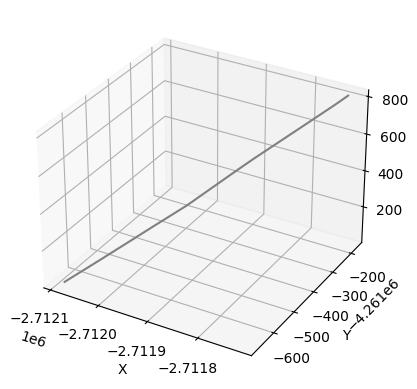

In [19]:
ax = plt.axes(projection="3d")
ax.plot3D(positions[:, 0], positions[:, 1], positions[:, 2], 'gray')
plt.xlabel("X")
plt.ylabel("Y")
ax.set_zlabel("Z")

In [31]:
adj = np.abs(positions[1:] - positions[:-1])
adj[:, 0].mean()

0.30428980454123633

In [7]:

times = np.load(segment_path / "global_pose/frame_times")
len(times)

1200

In [8]:
times[0: 40]

array([46408.547498, 46408.597506, 46408.647488, 46408.69749 ,
       46408.747491, 46408.797503, 46408.847508, 46408.89749 ,
       46408.947493, 46408.997484, 46409.047488, 46409.097498,
       46409.147488, 46409.197484, 46409.247486, 46409.297486,
       46409.347509, 46409.397485, 46409.447482, 46409.497487,
       46409.547494, 46409.597481, 46409.64748 , 46409.697474,
       46409.747473, 46409.797475, 46409.847478, 46409.897476,
       46409.947477, 46409.997482, 46410.047473, 46410.097474,
       46410.147475, 46410.197469, 46410.247482, 46410.297469,
       46410.347476, 46410.397469, 46410.447469, 46410.497466])

These are in ECEF or camera m/s

In [9]:

velocities = np.load(segment_path / "global_pose/frame_velocities")
velocities

array([[2.9047239 , 4.01603002, 6.20555644],
       [2.94151362, 4.05735186, 6.25606847],
       [2.9777254 , 4.09487774, 6.30539503],
       ...,
       [4.10014952, 5.3344189 , 9.66065472],
       [4.06634053, 5.26615064, 9.55497136],
       [4.01985485, 5.19355877, 9.45527469]])

# GNSS

GNSS is sampled at 10Hz in 60s for a total of. 


In [10]:
gnss_t = np.load(segment_path / "processed_log/GNSS/live_gnss_qcom/t")
gnss_t
len(gnss_t)

30

In [11]:
gnss_value = np.load(segment_path / "processed_log/GNSS/live_gnss_qcom/value")
gnss_value
len(gnss_value)

30

In [12]:
gnss_ublox = np.load(segment_path / "processed_log/GNSS/live_gnss_ublox/value")
len(gnss_ublox)

579

raw_gnss_qcom seems to be like the actual gnss data per frame

In [13]:
gnss_raw_qcom = np.load(segment_path / "processed_log/GNSS/raw_gnss_qcom/value")
len(gnss_raw_qcom)
gnss_raw_qcom[0]

array([ 2.00000000e+00,  2.01200000e+03,  4.04106399e+05,             nan,
        2.33368461e+07,  7.69716366e+01, -6.14895935e+02,  8.97800064e+00,
                   nan,             nan])

In [14]:
gnss_raw_ublox = np.load(segment_path / "processed_log/GNSS/raw_gnss_ublox/value")
len(gnss_raw_ublox)

9228

# Frames

So each video has 60s of video in a framerate of 20Hz, for a total of 1200 frames. 


In [15]:
frames = []
video = cv2.VideoCapture(str(segment_path / "video.hevc"))
while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break
    frames.append(frame)

In [16]:
len(frames)

1200

In [17]:
frames[0]

array([[[226, 193, 167],
        [232, 199, 173],
        [233, 200, 174],
        ...,
        [ 42,  39,  33],
        [ 43,  40,  34],
        [ 43,  40,  34]],

       [[231, 198, 172],
        [231, 198, 172],
        [235, 202, 176],
        ...,
        [ 43,  40,  34],
        [ 43,  40,  34],
        [ 43,  40,  34]],

       [[231, 198, 172],
        [232, 199, 173],
        [237, 204, 178],
        ...,
        [ 42,  39,  33],
        [ 42,  39,  33],
        [ 42,  39,  33]],

       ...,

       [[ 73,  60,  51],
        [ 72,  59,  50],
        [ 73,  60,  51],
        ...,
        [ 19,  11,   6],
        [ 19,  12,   4],
        [ 19,  12,   4]],

       [[ 66,  51,  38],
        [ 66,  51,  38],
        [ 63,  52,  43],
        ...,
        [ 18,  10,   5],
        [ 18,  10,   5],
        [ 18,  10,   5]],

       [[ 59,  44,  31],
        [ 57,  42,  29],
        [ 56,  45,  36],
        ...,
        [ 17,   9,   4],
        [ 17,   9,   4],
        [ 17,   9,   4]]

(1164, 874)

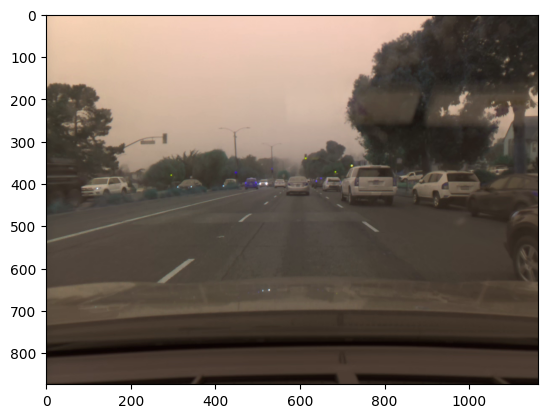

In [18]:

frame = frames[0]
image = Image.fromarray(frame, mode="RGB")
plt.imshow(image)
image.size